<a href="https://colab.research.google.com/github/tomaszgarbus/kaggle-vesuvius-challenge/blob/main/pretrained_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
except:
  pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!mkdir /kaggle
!mkdir /kaggle/input
!mkdir /kaggle/working
!ln -s /content/drive/Shareddrives/"Kaggle data"/vesuvius-challenge-ink-detection /kaggle/input/
!ln -s /content/drive/Shareddrives/"Kaggle data"/resnet50-pretrained /kaggle/input/
!ln -s /content/drive/Shareddrives/"Kaggle data"/working /kaggle/working

mkdir: cannot create directory ‘/kaggle’: File exists
mkdir: cannot create directory ‘/kaggle/input’: File exists
mkdir: cannot create directory ‘/kaggle/working’: File exists
ln: failed to create symbolic link '/kaggle/input/vesuvius-challenge-ink-detection': File exists
ln: failed to create symbolic link '/kaggle/input/resnet50-pretrained': File exists
ln: failed to create symbolic link '/kaggle/working/working': File exists


* https://github.com/qubvel/segmentation_models.pytorch

Imports

In [3]:
import torch
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from PIL import Image
from tqdm.auto import tqdm
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import numpy as np
from sklearn.metrics import fbeta_score, precision_score, recall_score
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
import datetime

from collections import defaultdict

import pandas as pd

import gc

import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

<ipython-input-3-cef96514c898>:9: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


Download the model. Ran once and created the Kaggle dataset

In [4]:
def download_and_save_resnet50(output_path):
    model = fcn_resnet50(FCN_ResNet50_Weights.DEFAULT)
    torch.save(model, output_path)

Constants & config

In [5]:
MODEL_PATH = '/kaggle/input/resnet50-pretrained/model'

YX_DIM = 32  # Specify only one dimension and use square patches.
Z_START = 26
Z_END = 32
Z_STEP = 2
Z_DIM = (Z_END - Z_START) // Z_STEP
assert Z_DIM == 3

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BSIZE = 256  # 256 is best
LR = 0.003

TQDM_OFF = False

PLOT_EVERY = 2  # Steps
MAX_STEPS = 10

TH = 0.5

Dataset definition

In [6]:
def load_mask(fragment_name, split_name):
    print(f"Loading mask {split_name}/{fragment_name}")
    return np.array(Image.open(f"/kaggle/input/vesuvius-challenge-ink-detection/{split_name}/{fragment_name}/mask.png"))

def load_inklabels(fragment_name, split_name):
    if split_name == 'test':
        return None
    print(f"Loading inklabels {split_name}/{fragment_name}")
    return np.array(Image.open(f"/kaggle/input/vesuvius-challenge-ink-detection/{split_name}/{fragment_name}/inklabels.png")).astype('float32')

def load_surface(fragment_name, split_name):
    print(f"Loading surface")
    surface = None
    for i in tqdm(range(Z_DIM), disable=TQDM_OFF):
        l = Z_START + i * Z_STEP
        sslice = np.array(Image.open(f"/kaggle/input/vesuvius-challenge-ink-detection/{split_name}/{fragment_name}/surface_volume/{l:02}.tif"))
        sslice = (sslice / 2**16).astype('float32')
        surface = surface if surface is not None else np.zeros([Z_DIM, *sslice.shape], dtype='float32')
        surface[i] = sslice
    return surface

class SlicedDataset(torch.utils.data.Dataset):
    def __init__(self, fragment_name, split_name):
        self.fragment_name = fragment_name
        self.split_name = split_name
        self.surface = load_surface(fragment_name, split_name)
        self.mask = load_mask(fragment_name, split_name)
        self.inklabels = load_inklabels(fragment_name, split_name)
        if self.inklabels is None:
            self.inklabels = np.zeros(self.mask.shape)

    def __len__(self):
        return (self.surface.shape[1] - YX_DIM) * (self.surface.shape[2] - YX_DIM)

    def getitem(self, y, x):
        surface = self.surface[:, y:y + YX_DIM, x:x + YX_DIM]
        labels = self.inklabels[y:y + YX_DIM, x:x + YX_DIM].reshape((1, YX_DIM, YX_DIM))
        return surface, labels, (y, x)

    def __getitem__(self, idx):
        y = idx // (self.surface.shape[2] - YX_DIM)
        x = idx % (self.surface.shape[2] - YX_DIM)
        return self.getitem(y, x)

In [7]:
x = SlicedDataset('1', 'train')
del x
gc.collect()

Loading surface


  0%|          | 0/3 [00:00<?, ?it/s]

Loading mask train/1
Loading inklabels train/1


59

Model definition

In [8]:
fcn_model = torch.load(MODEL_PATH)
fcn_model = fcn_model
# fcn_model.backbone.conv1 = torch.nn.Conv2d(
#     Z_DIM, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
fcn_model.classifier[4] = torch.nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))

fcn_model = fcn_model.to(DEVICE)

Freeze backbone, then unfreeze backbone.conv1

In [9]:
# for param in fcn_model.backbone.parameters():
#   param.requires_grad = False

# for param in fcn_model.backbone.conv1.parameters():
#   param.requires_grad = True

Train on fragments 1 and 2

Loading surface


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (140973980 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Loading mask train/2
Loading inklabels train/2


  0%|          | 0/4381133 [00:00<?, ?it/s]

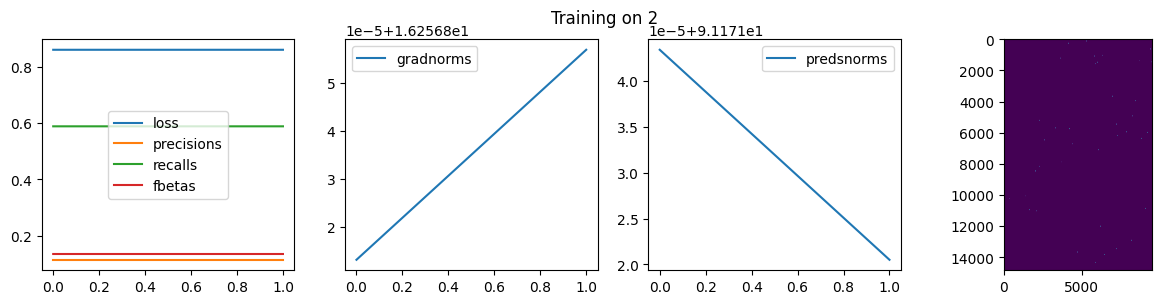

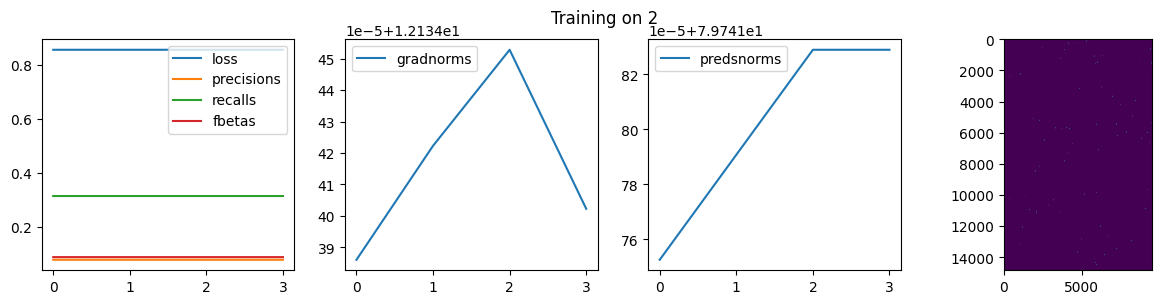

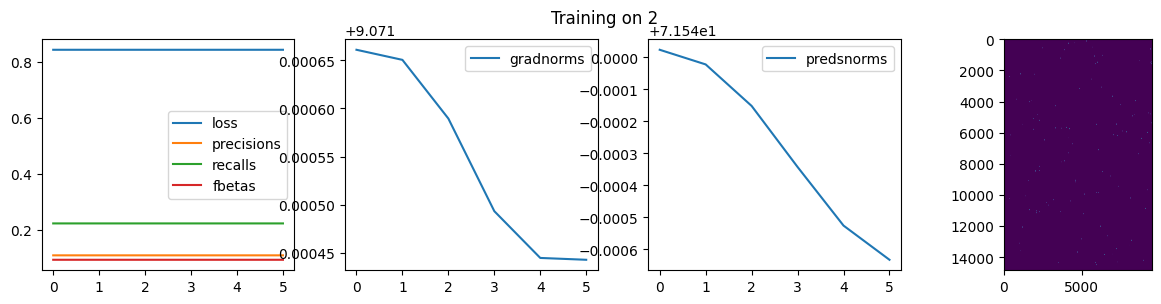

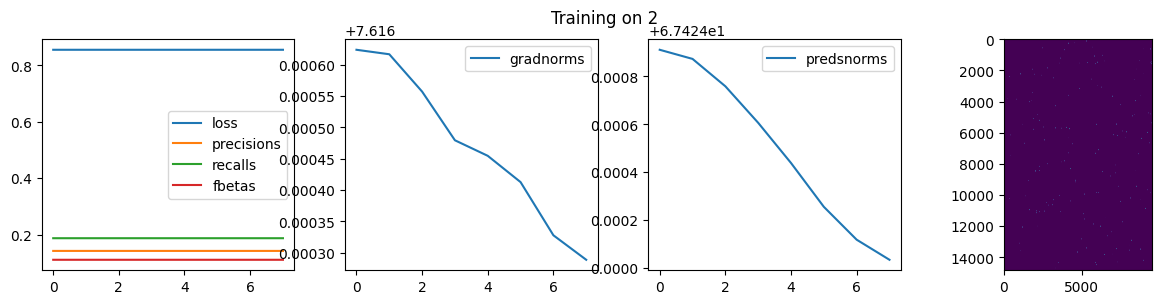

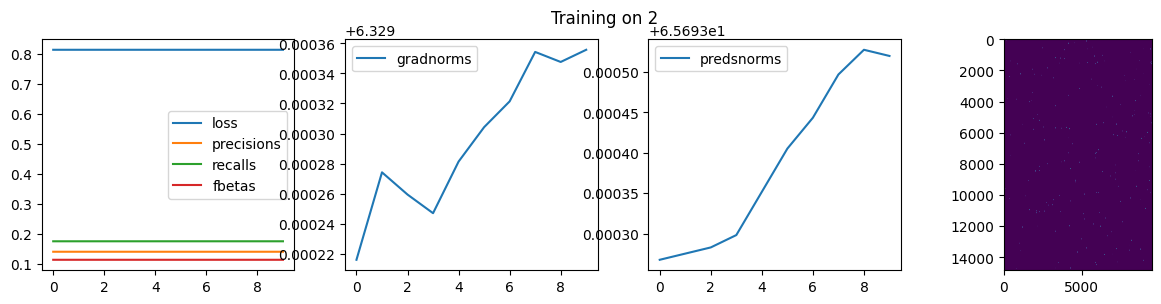

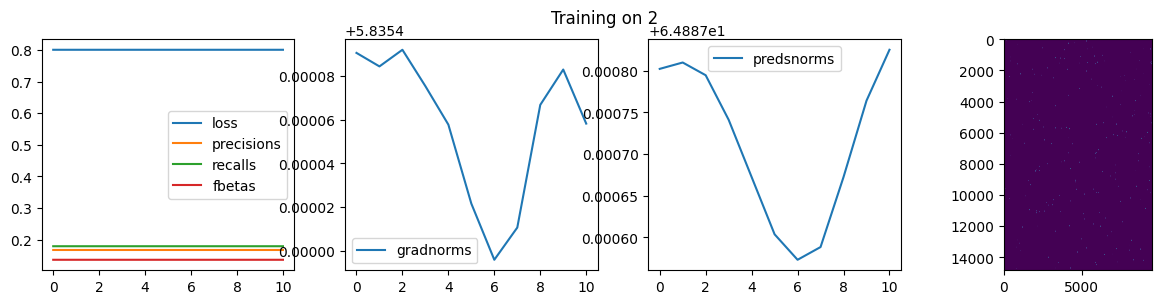

Loading surface


  0%|          | 0/3 [00:00<?, ?it/s]

Loading mask train/1
Loading inklabels train/1


  0%|          | 0/1603826 [00:00<?, ?it/s]

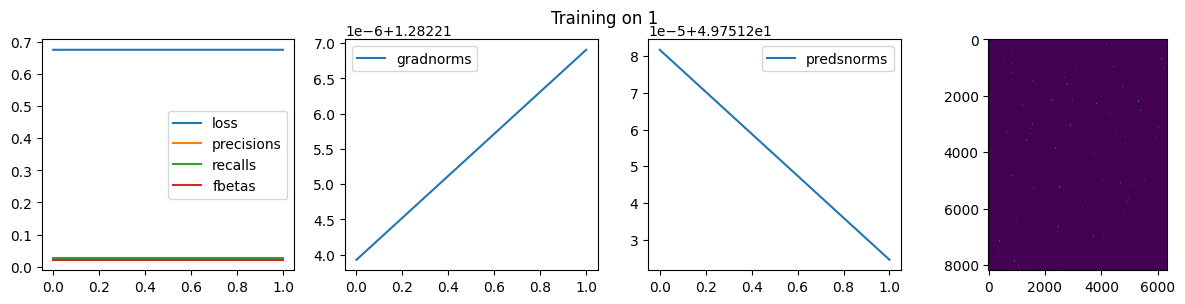

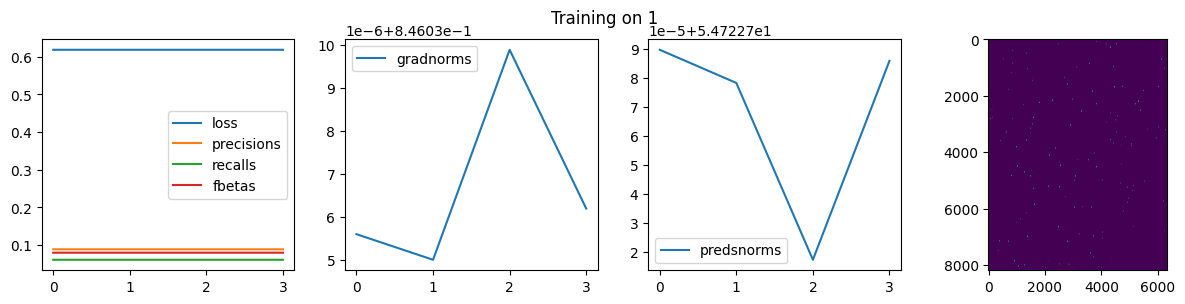

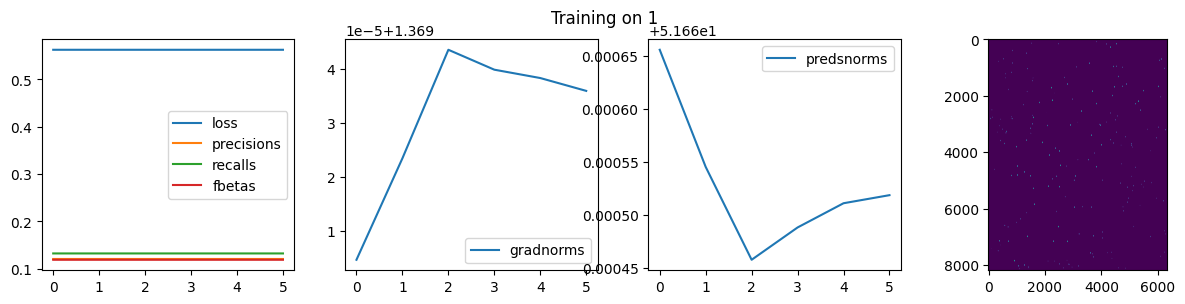

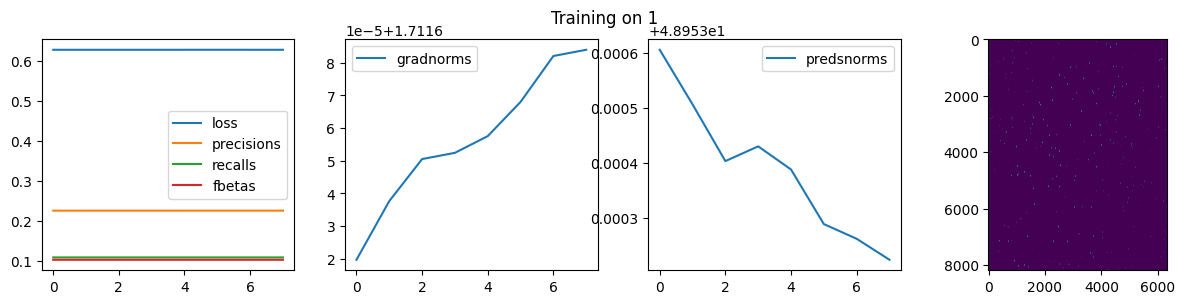

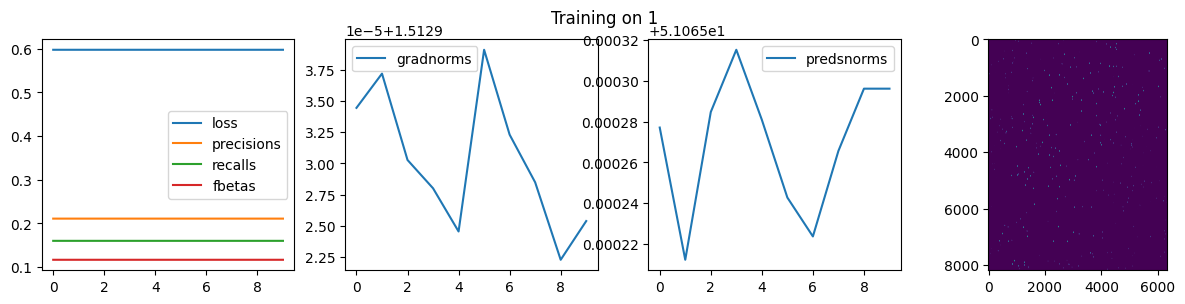

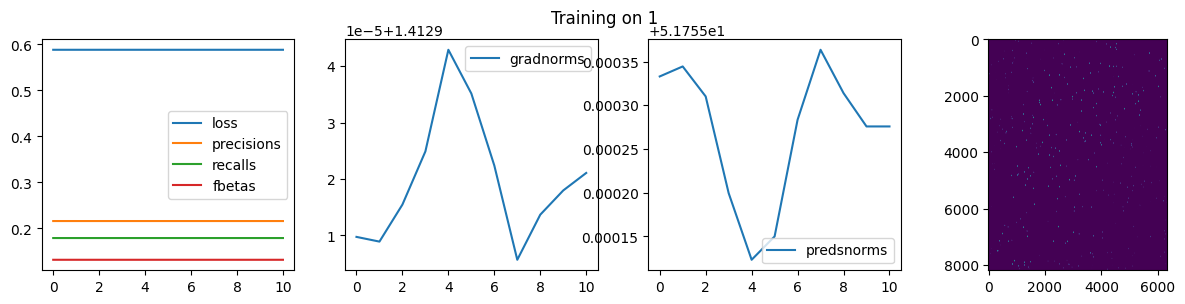

79179

In [10]:
def train_on_fragment(fragment_name):
    ds = SlicedDataset(fragment_name, 'train')
    dl = torch.utils.data.DataLoader(ds, batch_size=BSIZE, shuffle=True)
    class WeightedBCELoss(torch.nn.Module):
      def __init__(self):
          super().__init__()

      def forward(self, pred, actual):
          weights = torch.ones(actual.shape).to(DEVICE)
          weights[torch.where(actual == 1.)] = 3.
          return torch.nn.BCELoss(weights)(pred, actual)

    criterion = WeightedBCELoss()
    optimizer = torch.optim.Adam(fcn_model.parameters(), lr=LR)

    losses = []
    fbetas = []
    precisions = []
    recalls = []
    gradnorms = []
    predsnorms = []
    livegen = np.zeros(ds.surface.shape[1:])

    def gradnorm():
        grads = [
            param.grad.detach().flatten()
            for param in fcn_model.parameters()
            if param.grad is not None
        ]
        norm = torch.cat(grads).norm().cpu()
        return norm

    def plot():
        fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 3))
        fig.suptitle(f'Training on {fragment_name}')
        axs[0].plot(gaussian_filter1d(losses, sigma=25), label='loss')
        axs[0].plot(gaussian_filter1d(precisions, sigma=25), label='precisions')
        axs[0].plot(gaussian_filter1d(recalls, sigma=25), label='recalls')
        axs[0].plot(gaussian_filter1d(fbetas, sigma=25), label='fbetas')
        axs[1].plot(gaussian_filter1d(gradnorms, sigma=25), label='gradnorms')
        axs[2].plot(gaussian_filter1d(predsnorms, sigma=25), label='predsnorms')
        axs[3].imshow(livegen)
        axs[0].legend()
        axs[1].legend()
        axs[2].legend()
        plt.savefig(f'/kaggle/working/training_{fragment_name}_{datetime.datetime.now().strftime("%d-%m-%H:%M:%S")}.png')
        plt.show()

    for i, (surface, inklabels, (ys, xs)) in enumerate(pbar := tqdm(dl, disable=TQDM_OFF)):
        if i > MAX_STEPS:
            break
        optimizer.zero_grad()

        preds = torch.sigmoid(fcn_model(surface.to(DEVICE))['out'])
        pred_ink = preds.detach().gt(0.5).cpu().int()
        loss = criterion(preds, inklabels.to(DEVICE))
        loss.backward()
        optimizer.step()

        # TODO: vectorize
        for j in range(BSIZE):
          livegen[ys[j]:ys[j] + YX_DIM, xs[j]:xs[j] + YX_DIM] = preds[j, 0].detach().cpu().numpy()

        fbeta = fbeta_score(inklabels.view(-1).numpy(), pred_ink.view(-1).numpy(), beta=0.5)
        precision = precision_score(inklabels.view(-1).numpy(), pred_ink.view(-1).numpy())
        recall = recall_score(inklabels.view(-1).numpy(), pred_ink.view(-1).numpy())

        fbetas.append(fbeta)
        losses.append(loss.detach().cpu().float())
        precisions.append(precision)
        recalls.append(recall)
        gradnorms.append(gradnorm())
        predsnorms.append(preds.detach().norm().cpu())

        pbar.set_postfix({
            "loss": loss,
            "prec": precision,
            "rec": recall,
            "fbeta": fbeta,
            "gradnorm": gradnorms[-1],
            "predsnorm": predsnorms[-1]})

        if i % PLOT_EVERY == PLOT_EVERY - 1:
            plot()

    plot()

    # Cleanup
    del ds
    del dl
    del livegen

train_on_fragment('2')
gc.collect()
train_on_fragment('1')
gc.collect()

Define a function to generate the image

In [11]:
def generate_prediction(dataset):
    out = np.zeros(dataset.surface.shape[1:])
    # TODO: handle borders better
    for y in tqdm(range(0, dataset.surface.shape[1] - YX_DIM, YX_DIM), disable=TQDM_OFF):
        for x in range(0, dataset.surface.shape[2] - YX_DIM, YX_DIM):
            surface, _, _ = dataset.getitem(y, x)
            surface = torch.Tensor(np.expand_dims(surface, axis=0)).to(DEVICE)
            preds = torch.sigmoid(fcn_model(torch.Tensor(surface).to(DEVICE))['out'])
            out[y:y + YX_DIM, x:x + YX_DIM] = preds[0].detach().cpu().numpy()
    out *= dataset.mask
    out[np.where(out < TH)] = 0.
    out[np.where(out >= TH)] = 1.
    return out

Validate on fragment 3. Dipslay predicted image.

In [12]:
%%time

def eval():
    ds = SlicedDataset('3', 'train')
    out = generate_prediction(ds)
    fbeta = fbeta_score(ds.inklabels.flatten().astype(int), out.flatten().astype(int), beta=0.5)
    precision = precision_score(ds.inklabels.flatten().astype(int), out.flatten().astype(int))
    recall = recall_score(ds.inklabels.flatten().astype(int), out.flatten().astype(int))

    print(f"fbeta: {fbeta} precision: {precision} recall: {recall}")

eval()
gc.collect()

Loading surface


  0%|          | 0/3 [00:00<?, ?it/s]

Loading mask train/3
Loading inklabels train/3


  0%|          | 0/237 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

Test output serialization on train data

In [13]:
def rle(preds):
    preds = preds.flatten()
    starts = 2 + np.array(np.where(preds[1:] - preds[:-1] == 1.)).flatten()
    ends = 2 + np.array(np.where(preds[1:] - preds[:-1] == -1.)).flatten()
    return np.stack([starts, ends - starts], axis=1)

def serialize_rle(rle):
    return ' '.join(f"{x[0]} {x[1]}" for x in rle)

In [ ]:
ds = SlicedDataset('3', 'train')
print(serialize_rle(rle(ds.inklabels)))
!cat /kaggle/input/vesuvius-challenge-ink-detection/train/3/inklabels_rle.csv

Loading surface


  0%|          | 0/3 [00:00<?, ?it/s]

Loading mask train/3
Loading inklabels train/3
4323222 18 4328469 21 4333717 24 4333757 7 4338966 25 4339002 17 4344214 54 4349462 55 4354710 56 4359956 60 4365199 66 4370447 68 4375696 69 4380945 70 4386193 71 4391441 73 4396689 75 4401929 85 4407174 90 4412421 93 4417670 95 4422919 98 4428168 98 4433417 98 4438666 99 4443915 100 4449164 101 4454412 105 4459660 106 4464908 108 4470155 110 4475401 113 4480649 115 4485896 118 4491144 120 4496392 122 4501640 132 4506887 134 4512124 146 4517373 147 4522622 148 4527871 149 4533120 151 4538369 153 4543618 154 4548867 155 4554116 156 4559364 158 4564612 160 4569860 162 4575108 164 4580355 168 4585600 180 4590849 182 4596098 183 4601346 185 4605532 11 4606595 186 4610749 4 4610777 16 4611843 187 4615994 8 4616022 22 4617091 189 4621241 11 4621267 27 4622339 190 4626490 12 4626514 31 4627587 191 4631739 13 4631759 42 4632835 192 4636988 63 4637056 9 4638083 194 4642236 82 4643332 194 4647484 106 4648166 12 4648580 196 4652732 107 4653413 17 46

Generate test predictions

In [ ]:
submission = defaultdict(list)

for fragment_name in os.listdir('/kaggle/input/vesuvius-challenge-ink-detection/test/'):
    ds = SlicedDataset(fragment_name, 'test')
    out = generate_prediction(ds)

    submission["Id"].append(fragment_name)
    submission["Predicted"].append(serialize_rle(rle(out)))

pd.DataFrame.from_dict(submission).to_csv("/kaggle/working/submission.csv", index=False)

Loading surface


  0%|          | 0/3 [00:00<?, ?it/s]

Loading mask test/a


  0%|          | 0/85 [00:00<?, ?it/s]

In [ ]:
pd.DataFrame.from_dict(submission)

In [ ]:
!cut -c-100 /kaggle/working/submission.csv